In [1]:
from impala.dbapi import connect
import pandas as pd
from collections import defaultdict
import trueskill as ts
import multiprocessing as mps
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.special import factorial
import math

### 连接HUE并取数据

In [2]:
conn = connect(host='10.8.8.21', port=10015, auth_mechanism='PLAIN', database='tmp', user='shenfei',password='123456')
cursor = conn.cursor()
cursor.execute('''
SELECT t1.*, t2.goal_id
FROM
(
    SELECT id, u_user, problem_id,duration, day, correct, u_school, from_unixtime(event_time/1000) AS time
    FROM events.frontend_event_orc
    WHERE day BETWEEN 20181001 AND 20181031
      AND event_key = 'clickLTTPSumbit'
      AND u_user != ''
      AND u_user IS NOT NULL
      AND u_school IS NOT NULL
      AND u_school IN ('新民中学', '莒南七中', '临沂十一中', '南宁二中', '广东实验中学', '双语学校', '武陵中学', '吴有训实验学校', '武侯实验中学', '城关中学')
)t1
INNER JOIN
(
    SELECT id, goal_id
    FROM course.problem
)t2 ON t1.problem_id = t2.id
ORDER BY t1.day,t1.time ASC
''')

data = cursor.fetchall()
data = pd.DataFrame(data)
data.columns = ['id', 'uid', 'pid', 'dur', 'day', 'corr', 'sch_name', 'time', 'gid']
data['ts_pts'] = 0
data['dur_weight'] = 0
data['win_proba_weight'] = 0

### 丢掉duration为负数的数据，查看一下——

In [3]:
data.drop(data[data.dur < 0].index,axis=0,inplace=True)
data.head(5)

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts,dur_weight,win_proba_weight
0,5bb198a54e4fa563c91db6fa,5b2727891751372c1abfe883,c3f60db4-57e8-11e7-bcc6-efe430075243,5216,20181001,1,武侯实验中学,2018-09-22 17:51:22,98b8c97c-53f4-11e7-86c5-ff3a4f54ef59,0,0,0
1,5bb198a54e4fa563c91db70f,5b2727891751372c1abfe883,1f3dc49a-9c28-11e7-b43c-c3e3d844847d,17858,20181001,0,武侯实验中学,2018-09-22 17:51:41,98b13b6c-53f4-11e7-86c3-070b5be9dad9,0,0,0
2,5bb198a54e4fa563c91db730,5b2727891751372c1abfe883,8b0d6018-9c28-11e7-98c6-132f70b41865,37784,20181001,1,武侯实验中学,2018-09-22 17:52:23,98b13b6c-53f4-11e7-86c3-070b5be9dad9,0,0,0
3,5bb198a54e4fa563c91db86a,5b2727891751372c1abfe883,72c98570-f06c-11e7-8c4b-3f039c800832,104748,20181001,1,武侯实验中学,2018-09-22 17:54:29,9c265610-53f4-11e7-87dd-23717d4fac41,0,0,0
4,5bb198a54e4fa563c91db888,5b2727891751372c1abfe883,a9084308-f06f-11e7-bee4-4700dd2ee098,114514,20181001,0,武侯实验中学,2018-09-22 17:56:25,9c5bb648-53f4-11e7-87ee-2f3a7d5214d9,0,0,0


$$compensate = \left (\frac{\mu_{g}}{\mu_{u}} - 1  \right ) \cdot b$$  

$$\Delta = \frac{\mu_g}{\mu_u} \cdot norm\_d(duration) + compensate,$$

$$ 
norm\_duration(d)=
\begin{cases}
correct:& 
\begin{cases}
\left ( \frac{2000}{2000} \right )^{0.3}=1   &&   {d < 2000}\\
\left ( \frac{2000}{d} \right )^{0.3}    &&    {2000 < d < 600000}\\
\left ( \frac{2000}{600000} \right )^{0.3}\approx 0.18  &&  {d > 600000}
\end{cases}  \\
incorrect:& 
\begin{cases}
durToWeight(d)&      & {part1}\\
win\_proba(user,goal) &      & {part2}
\end{cases} 
\end{cases}
$$

## 绘图观察并用二次函数对<font color=#FF7F50>第一段(第一个峰)</font>(duration<7829.45)进行拟合：

In [4]:
pick_dur = data[['gid','dur','corr']]
draw_qcut = pick_dur.groupby(pd.qcut(pick_dur.dur,q=150)).apply(lambda x:sum(x['corr']==0)/len(x))
mid_point =[i.mid for i in draw_qcut.index]

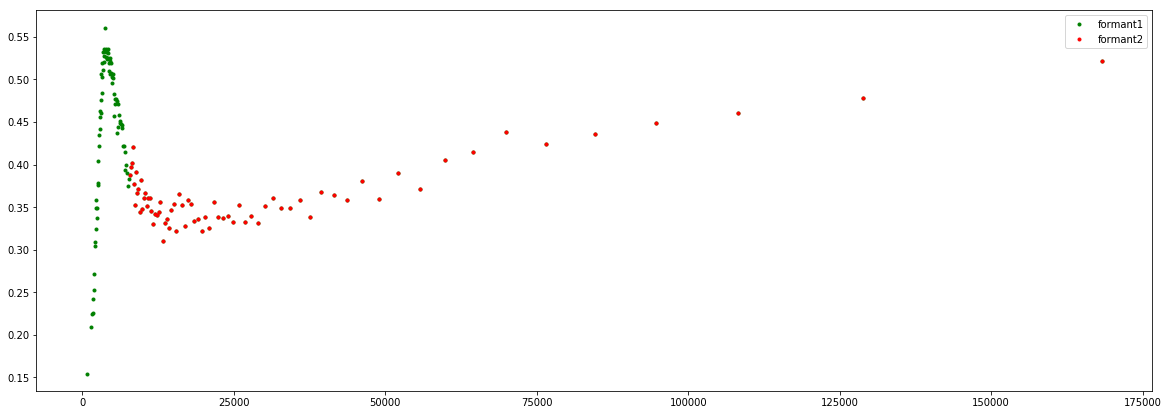

In [5]:
rate_pop = draw_qcut.pop(draw_qcut.index.max())
rate_top = draw_qcut.max()
mid_point.pop()
plt.rcParams['figure.figsize'] = (20,7)
mid_point = np.array(mid_point)

plt.plot(mid_point,draw_qcut,'g.',label='formant1')
plt.plot(mid_point[mid_point > 7829.45],draw_qcut[sum(mid_point < 7829.45):],'r.',label='formant2')
plt.legend(loc='best')

### 用duration<5000的数据，建立二次函数模型拟合之：

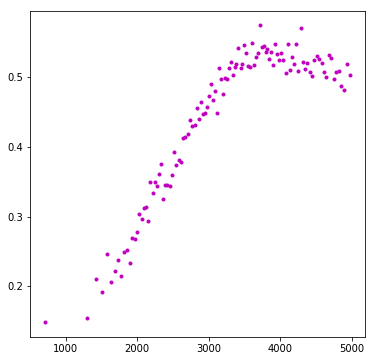

In [6]:
# 加这个dur<17500的数据完全是为了后面画图好看：
dur_17500 = pick_dur[pick_dur['dur'] < 17500]
dur_17500_rate = dur_17500.groupby(pd.qcut(dur_17500['dur'],q=240)).apply(lambda x:sum(x['corr'] == 0)/len(x))
# dur_17500_cnt = dur_17500.groupby(pd.qcut(dur_17500['dur'],q=240)).apply(lambda x:len(x))
mid_17500 = [i.mid for i in dur_17500_rate.index]
mid_17500 = np.array(mid_17500)

mid_5000 = mid_17500[mid_17500<5000]
dur_5000_rate = dur_17500_rate[:len(mid_5000)]

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.plot(mid_5000,dur_5000_rate,'m.')

In [7]:
#二次曲线方程
def f_2(x, A, B, C):
    return A*x*x + B*x + C

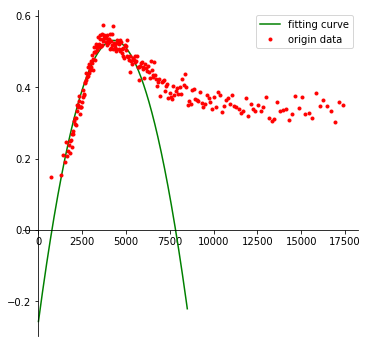

In [8]:
a,b,c = optimize.curve_fit(f_2,mid_5000,dur_5000_rate)[0]
X = np.linspace(0,8500,400)
y_hat = a*X*X + b*X + c

# 获取当前的坐标轴, gca = get current axis
ax = plt.gca()
# 设置右边框和上边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# 设置x坐标轴为下边框
ax.xaxis.set_ticks_position('bottom')
# 设置y坐标轴为左边框
ax.yaxis.set_ticks_position('left')
# 设置x轴, y周在(0, 0)的位置
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))

plt.plot(X,y_hat,'g-',label='fitting curve')
plt.plot(mid_17500,dur_17500_rate,'r.',label='origin data')
plt.legend(loc='best')

In [9]:
def formant1(x):
    return a * x**2 + b * x + c

In [10]:
# 计算两个零点，并用大零点反过来验证，的确可以用作当第二段的开头；
(-b + np.sqrt(b*b - 4*a*c))/(2*a) , (-b - np.sqrt(b*b - 4*a*c))/(2*a)

(768.9791726335619, 7829.45867862655)

### 对<font color=#FF7F50>第二段</font>(duration>7829.45)进行处理：
- ~99.96%+的用户在600s内解决战斗（见下），~95%用户在80s内解决战斗。下面我们共cut成150个区间，并绘图，看看在什么时间里有最多的user提交

In [11]:
sum(pick_dur['dur'] < 600000) / len(pick_dur),pick_dur['dur'].min()

(0.9995961512098791, 209)

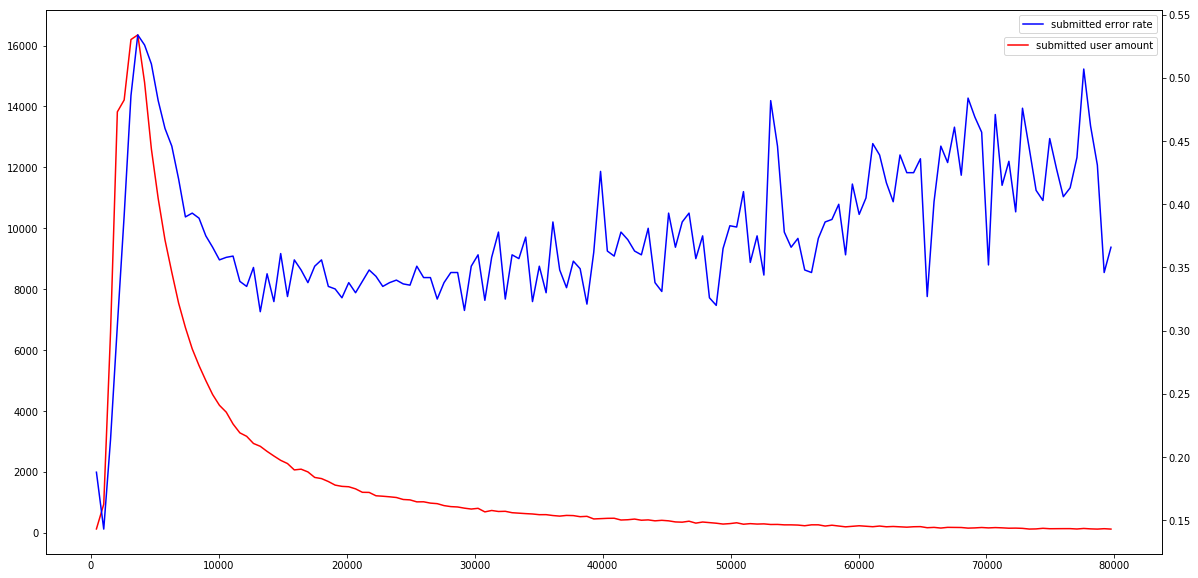

In [12]:
less_80s_dur = pick_dur[pick_dur['dur'] < 80000]
count_dur = less_80s_dur.groupby(pd.cut(less_80s_dur['dur'],bins=150)).apply(lambda x:(len(x),round(sum(x['corr']==0)/len(x),3)))

mid3 = [round(i.mid,3) for i in count_dur.index]
draw_cnt=[]
draw_err_rate=[]
for i in count_dur:
    draw_cnt.append(i[0])
    draw_err_rate.append(i[1])
    
fig4 = plt.figure(figsize=(20,10))

ax1 = fig4.add_subplot(111)
l1 = ax1.plot(mid3,draw_cnt,'r',label='submitted user amount')
plt.legend(bbox_to_anchor=(1, 0.96))

ax2 = ax1.twinx()  # this is the important function
l2 = ax2.plot(mid3,draw_err_rate,'b',label='submitted error rate')
plt.legend(loc='best')

### 两段duration的处理，以7829.45为分界线，分别缩放到-0.5~0；然后再相加,使区间变为[-1,0]
- 其中，第一段直接用二次函数取值和其峰值的比值作为权重，若二次函数值小于0则直接置0；
- 第二段，duration小于80000的，用duration/80000为权重，大于80000，直接置1。

In [13]:
# 将输入的duration按段转换成权值小数，区间[-0.5,0.5]：
def durToWeight(x):
    if x < 7829.45:
        summit = (4*a*c - b**2)/(4*a)
        return (formant1(x)/summit)*(-0.5) if formant1(x)>0 else 0
    else:
        x = min(x,600000)
        return (x/600000) * 0.5

In [14]:
def win_proba(user,goal):
    delta_mu = user.mu - goal.mu
    sum_sigma = user.sigma**2 + goal.sigma**2
    size = 2
    denom = math.sqrt(size * (ts.BETA * ts.BETA) + sum_sigma)
    tse = ts.global_env()
    return tse.cdf(delta_mu / denom)

In [15]:
def norm_duration(item,idx,u_player,g_player,data):
    if item['corr'] == 1:
        d = item['dur']
        d = max(2000, d)
        d = min(d, 600000)
        data.loc[idx,'dur_weight'] = np.nan
        data.loc[idx,'win_proba_weight'] = np.nan
        return (2000/d) ** 0.3
    else:
        d = item['dur']
        weight1 = 0.5 * (durToWeight(d) - 0.5)
        weight2 = -0.5*win_proba(u_player,g_player)
        data.loc[idx,'dur_weight'] = weight1
        data.loc[idx,'win_proba_weight'] = weight2
        return weight1 + weight2

In [16]:
def cal_TrueSkill(data):
    user = defaultdict(ts.Rating)
    goal = defaultdict(ts.Rating)
    
    for i in data.iterrows():
        idx = i[0]
        item = i[1]
        # 对每一条迭代进来的记录，分别初始化uid和pid的能力值，然后用上式计算。
        u_player = user[item['uid']]
        g_player = goal[item['gid']]
        
        # 核心句，计算一次做题提交之后，trueskill的变化。根据user做题的对错情况，决定这个delta数值是正还是负。
        data.loc[idx,'ts_pts'] = (g_player.mu / u_player.mu)*norm_duration(item,idx,u_player,g_player,data)
        # 记录即时的goal与user值，是为了后面计算compensate
        data.loc[idx,'temp_g'] = g_player.mu
        data.loc[idx,'temp_u'] = u_player.mu
    
        if item['corr']:
            u_player,g_player = ts.rate_1vs1(u_player,g_player)
        else :
            g_player,u_player = ts.rate_1vs1(g_player,u_player)
            
        user[item['uid']] = u_player
        goal[item['gid']] = g_player
    return user,goal,data
# user/goal两个defaultdict分别存储某个user或某个goal的实时trueskill；data的‘ts_pts’列，存储该条记录对战过后，user应该发生的trueskill变化

In [17]:
def split_data(cores,data):
    split_num = np.linspace(0,len(data),5,dtype=int)
    data_seg = [data[split_num[j]:split_num[j+1]] for j in range(len(split_num)-1)]
    return data_seg

### 采用多进程方法进行计算每条记录的‘ts_pts’：

In [18]:
cores = mps.cpu_count()
pool = mps.Pool(processes=cores)

r = []
data_seg = split_data(cores,data)
for i in data_seg:
    r.append(pool.apply_async(cal_TrueSkill, (i,))) 

pool.close()
pool.join()

res = [i.get() for i in r]
data = pd.concat([i[2] for i in res])

user_ts = defaultdict(ts.Rating)
goal_ts = defaultdict(ts.Rating)

for i in res:
    user_ts.update(i[0])
    goal_ts.update(i[1])

### 看一眼数据

In [20]:
data

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts,dur_weight,win_proba_weight,temp_g,temp_u
0,5bb198a54e4fa563c91db6fa,5b2727891751372c1abfe883,c3f60db4-57e8-11e7-bcc6-efe430075243,5216,20181001,1,武侯实验中学,2018-09-22 17:51:22,98b8c97c-53f4-11e7-86c5-ff3a4f54ef59,0.750080,NaN,NaN,25.000000,25.000000
1,5bb198a54e4fa563c91db70f,5b2727891751372c1abfe883,1f3dc49a-9c28-11e7-b43c-c3e3d844847d,17858,20181001,0,武侯实验中学,2018-09-22 17:51:41,98b13b6c-53f4-11e7-86c3-070b5be9dad9,-0.477470,-0.242559,-0.318866,25.000000,29.395832
2,5bb198a54e4fa563c91db730,5b2727891751372c1abfe883,8b0d6018-9c28-11e7-98c6-132f70b41865,37784,20181001,1,武侯实验中学,2018-09-22 17:52:23,98b13b6c-53f4-11e7-86c3-070b5be9dad9,0.514391,NaN,NaN,30.997127,24.954247
3,5bb198a54e4fa563c91db86a,5b2727891751372c1abfe883,72c98570-f06c-11e7-8c4b-3f039c800832,104748,20181001,1,武侯实验中学,2018-09-22 17:54:29,9c265610-53f4-11e7-87dd-23717d4fac41,0.259956,NaN,NaN,25.000000,29.329526
4,5bb198a54e4fa563c91db888,5b2727891751372c1abfe883,a9084308-f06f-11e7-bee4-4700dd2ee098,114514,20181001,0,武侯实验中学,2018-09-22 17:56:25,9c5bb648-53f4-11e7-87ee-2f3a7d5214d9,-0.445804,-0.202286,-0.348740,25.000000,30.900679
5,5bb198a54e4fa563c91db8b6,5b2727891751372c1abfe883,1028d2a2-f069-11e7-ad5a-330fe624e669,182199,20181001,0,武侯实验中学,2018-09-22 17:59:32,9c23bb44-53f4-11e7-87dc-03848bcaedef,-0.425637,-0.174084,-0.305364,25.000000,28.160576
6,5bb1e36f4e4fa563c97e687b,5ba205906879cb0637199630,c47cb4cc-57e8-11e7-bcf2-fbd950083b45,26284,20181001,0,临沂十一中,2018-09-30 13:36:28,98cbda1c-53f4-11e7-86cc-afd330b1bf7a,-0.489048,-0.239048,-0.250000,25.000000,25.000000
7,5bb1e36f4e4fa563c97e68b4,5ba205906879cb0637199630,c53bcc4a-57e8-11e7-bd25-af882142eedc,10056,20181001,0,临沂十一中,2018-09-30 13:36:42,98d74d3e-53f4-11e7-86cf-8b947f482f5e,-0.518031,-0.245810,-0.181134,25.000000,20.604168
8,5bb1e36f4e4fa563c97e68e6,5ba205906879cb0637199630,c532b754-57e8-11e7-bd23-8f5f72183a4e,3288,20181001,0,临沂十一中,2018-09-30 13:36:53,98d74d3e-53f4-11e7-86cf-8b947f482f5e,-0.897412,-0.479487,-0.089478,28.458391,18.042819
9,5bb1c7fa4e4fa563c900f936,5ba1b5a6f2716f063187c7af,091b3e92-7c1e-11e7-bc9d-4f970e64977d,32263,20181001,0,武陵中学,2018-09-30 17:36:08,96a01c62-53f4-11e7-8615-c7a25e0cd590,-0.486557,-0.236557,-0.250000,25.000000,25.000000


### 有了未被弥补过的ts_pts之后，我们根据它来计算弥补值的系数b：

In [21]:
u_ts_max = max(list(map(lambda x:x.mu,list(user_ts.values()))))
u_ts_min = min(list(map(lambda x:x.mu,list(user_ts.values()))))
g_ts_max = max(list(map(lambda x:x.mu,list(goal_ts.values()))))
g_ts_min = min(list(map(lambda x:x.mu,list(goal_ts.values()))))
b1 = g_ts_min*(2000/600000)**0.3/(u_ts_max-g_ts_min)
b2 = g_ts_max/(g_ts_max-u_ts_min)
b = min(b1,b2)
b

0.07933374094389903

### 有了b之后，我们开始逐行计算弥补项compensate，以及加上compensate更新之后的ts_pts:

In [22]:
def ts_update(data,b):
    for i,row in data.iterrows():
        compensate = (row['temp_g'] / row['temp_u'] - 1) * b
        data.loc[i,'compensate'] = compensate
        data.loc[i,'ts_pts'] = data.loc[i,'ts_pts'] + compensate
    return data

In [23]:
pool2 = mps.Pool(processes=cores)

r2 = []
data_seg2 = split_data(cores,data)
for i in data_seg2:
    r2.append(pool2.apply_async(ts_update,args=(i,b,)))

pool2.close()
pool2.join()

res2 = [i.get() for i in r2]
data = pd.concat([i for i in res2])

### 看一下compensate之后的data：

In [24]:
data

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts,dur_weight,win_proba_weight,temp_g,temp_u,compensate
0,5bb198a54e4fa563c91db6fa,5b2727891751372c1abfe883,c3f60db4-57e8-11e7-bcc6-efe430075243,5216,20181001,1,武侯实验中学,2018-09-22 17:51:22,98b8c97c-53f4-11e7-86c5-ff3a4f54ef59,0.750080,NaN,NaN,25.000000,25.000000,0.000000
1,5bb198a54e4fa563c91db70f,5b2727891751372c1abfe883,1f3dc49a-9c28-11e7-b43c-c3e3d844847d,17858,20181001,0,武侯实验中学,2018-09-22 17:51:41,98b13b6c-53f4-11e7-86c3-070b5be9dad9,-0.489334,-0.242559,-0.318866,25.000000,29.395832,-0.011864
2,5bb198a54e4fa563c91db730,5b2727891751372c1abfe883,8b0d6018-9c28-11e7-98c6-132f70b41865,37784,20181001,1,武侯实验中学,2018-09-22 17:52:23,98b13b6c-53f4-11e7-86c3-070b5be9dad9,0.533603,NaN,NaN,30.997127,24.954247,0.019211
3,5bb198a54e4fa563c91db86a,5b2727891751372c1abfe883,72c98570-f06c-11e7-8c4b-3f039c800832,104748,20181001,1,武侯实验中学,2018-09-22 17:54:29,9c265610-53f4-11e7-87dd-23717d4fac41,0.248245,NaN,NaN,25.000000,29.329526,-0.011711
4,5bb198a54e4fa563c91db888,5b2727891751372c1abfe883,a9084308-f06f-11e7-bee4-4700dd2ee098,114514,20181001,0,武侯实验中学,2018-09-22 17:56:25,9c5bb648-53f4-11e7-87ee-2f3a7d5214d9,-0.460954,-0.202286,-0.348740,25.000000,30.900679,-0.015149
5,5bb198a54e4fa563c91db8b6,5b2727891751372c1abfe883,1028d2a2-f069-11e7-ad5a-330fe624e669,182199,20181001,0,武侯实验中学,2018-09-22 17:59:32,9c23bb44-53f4-11e7-87dc-03848bcaedef,-0.434541,-0.174084,-0.305364,25.000000,28.160576,-0.008904
6,5bb1e36f4e4fa563c97e687b,5ba205906879cb0637199630,c47cb4cc-57e8-11e7-bcf2-fbd950083b45,26284,20181001,0,临沂十一中,2018-09-30 13:36:28,98cbda1c-53f4-11e7-86cc-afd330b1bf7a,-0.489048,-0.239048,-0.250000,25.000000,25.000000,0.000000
7,5bb1e36f4e4fa563c97e68b4,5ba205906879cb0637199630,c53bcc4a-57e8-11e7-bd25-af882142eedc,10056,20181001,0,临沂十一中,2018-09-30 13:36:42,98d74d3e-53f4-11e7-86cf-8b947f482f5e,-0.501105,-0.245810,-0.181134,25.000000,20.604168,0.016926
8,5bb1e36f4e4fa563c97e68e6,5ba205906879cb0637199630,c532b754-57e8-11e7-bd23-8f5f72183a4e,3288,20181001,0,临沂十一中,2018-09-30 13:36:53,98d74d3e-53f4-11e7-86cf-8b947f482f5e,-0.851615,-0.479487,-0.089478,28.458391,18.042819,0.045797
9,5bb1c7fa4e4fa563c900f936,5ba1b5a6f2716f063187c7af,091b3e92-7c1e-11e7-bc9d-4f970e64977d,32263,20181001,0,武陵中学,2018-09-30 17:36:08,96a01c62-53f4-11e7-8615-c7a25e0cd590,-0.486557,-0.236557,-0.250000,25.000000,25.000000,0.000000


### 计算下列内容：
- 1.某学校总做题量；                                **final_res['做题量']**
- 2.参与进来的用户总数；                             **final_res['用户总数']**
- 3.某学校每位用户平均做题量；                        **final_res['人均题量']**
- 4.利用F1积分法等方法得到的合理的学校总分；            **final_res['总分Func']**
- 5.学校学生的平均trueskill；                      **final_res['人均TrueSkill']**
- 6.每个学校涉及到的知识点goal总数；                 **final_res['知识点数']**                      
- 7.本学校拿到前三名的知识点goal数量；

In [25]:
final_res = pd.DataFrame(dict())

In [26]:
final_res['做题量'] = data.groupby('sch_name').apply(lambda x: len(x))

In [27]:
uid_count = [len(x) for x in data.groupby('sch_name').uid.unique()]

final_res['用户总数'] = uid_count
final_res['人均题量'] = final_res['做题量'].values / uid_count

In [28]:
sch_user_ts = data[['uid','sch_name']]
sch_user_ts = sch_user_ts.drop_duplicates()
sch_user_ts['trueskill'] = sch_user_ts.uid.apply(lambda x:user_ts[x].mu)  
# 因为我们无法把duration的计算加入trueskill公式中，因而在计算trueskill的只好忽略掉它。但涉及到最后排名时，duration会被用上。
final_res['人均TrueSkill'] = sch_user_ts.groupby('sch_name').apply(lambda x:x['trueskill'].mean())

In [29]:
final_res['知识点数'] = data.groupby('sch_name').apply(lambda x:len(x.gid.unique()))

In [30]:
# 每个知识点下每个学校得分排名：
F1_score = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6, 8:4, 9:2, 10:1}

rs = data.groupby(['gid','sch_name']).apply(lambda x: sum(x.ts_pts))
rs = pd.DataFrame(rs).reset_index()
rs.columns = ['gid', 'sch_name', 'pt']
rs['rank_int'] = rs[['gid', 'pt']].groupby(['gid']).rank(ascending=0)
rs['rank_pct'] = rs[['gid','pt']].groupby('gid').rank(ascending=True,method='max',pct=True)
rs['Func_pt'] = rs['rank_pct'].apply(lambda x:pow((x**8),1/3)*25)
rs['F1_pt'] = rs['rank_int'].apply(lambda x:F1_score.get(x,0))
rs.head(10)

,gid,sch_name,pt,rank_int,rank_pct,Func_pt,F1_pt
0,006f814e-b329-11e7-aab6-b3208c44f7d9,临沂十一中,0.663866,2.0,0.8,13.788382,18
1,006f814e-b329-11e7-aab6-b3208c44f7d9,南宁二中,0.195069,3.0,0.6,6.402408,15
2,006f814e-b329-11e7-aab6-b3208c44f7d9,新民中学,-0.242621,4.0,0.4,2.171534,12
3,006f814e-b329-11e7-aab6-b3208c44f7d9,武陵中学,2.195428,1.0,1.0,25.000000,25
4,006f814e-b329-11e7-aab6-b3208c44f7d9,莒南七中,-2.687164,5.0,0.2,0.341995,10
5,01f90096-7123-11e7-b3a9-2b20ad1b4a83,临沂十一中,0.507876,4.0,0.4,2.171534,12
6,01f90096-7123-11e7-b3a9-2b20ad1b4a83,南宁二中,-0.474142,5.0,0.2,0.341995,10
7,01f90096-7123-11e7-b3a9-2b20ad1b4a83,新民中学,4.747333,2.0,0.8,13.788382,18
8,01f90096-7123-11e7-b3a9-2b20ad1b4a83,武陵中学,3.136578,3.0,0.6,6.402408,15
9,01f90096-7123-11e7-b3a9-2b20ad1b4a83,莒南七中,6.110518,1.0,1.0,25.000000,25


In [31]:
final_res['总分Func'] = rs.groupby('sch_name').apply(lambda x:sum(x['Func_pt']))
final_res['总分F1'] = rs.groupby('sch_name').apply(lambda x:sum(x['F1_pt']))
final_res['平均顺位'] = rs.groupby('sch_name').apply(lambda x:x['rank_int'].mean())
final_res['得到第一的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] == 1))
final_res['得到前二的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] < 2.1))
final_res['得到前三的次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] < 3.1))
final_res['6名开外次数'] = rs.groupby('sch_name').apply(lambda x:sum(x['rank_int'] > 6.9))

In [32]:
final_res.sort_values(by='总分Func',ascending=False)
# 注意吴有训和双语，吴有训在Func中反超了双语，就是因为他们前二名的次数明显多于双语学校。可见Func法对排名靠前的学校的得分有较好的区分度

,做题量,用户总数,人均题量,人均TrueSkill,知识点数,总分Func,总分F1,平均顺位,得到第一的次数,得到前二的次数,得到前三的次数,6名开外次数
sch_name,,,,,,,,,,,,
莒南七中,93206,608,153.299342,26.924594,934,13968.287847,16955,2.689507,407,572,690,73
武陵中学,70309,601,116.986689,26.377827,911,9009.641507,13299,3.701427,178,391,522,150
临沂十一中,56678,808,70.146040,26.693242,854,7931.974917,12159,3.670960,114,275,501,106
新民中学,14736,348,42.344828,27.695989,845,7604.055216,11961,3.671006,120,270,394,72
城关中学,12764,482,26.481328,27.830107,568,4977.899085,7425,4.177817,80,166,241,107
南宁二中,5017,154,32.577922,27.694121,604,3975.816438,7018,4.622517,44,119,179,116
双语学校,11149,347,32.129683,26.915686,450,3094.612878,5093,4.777778,34,74,140,102
吴有训实验学校,3412,113,30.194690,27.075491,403,2801.337225,4570,4.838710,41,79,122,111
广东实验中学,1705,67,25.447761,27.750621,380,2161.076796,3958,5.176316,24,55,100,105


### 以吴有训实验学校为例，计算该校每个用户对于学校总成绩的贡献值：
- 以百分数形式表现

In [33]:
wu = data[data['sch_name'] == '吴有训实验学校']
ts_wu = pd.DataFrame(dict())
ts_wu['ts'] = wu.groupby('uid').apply(lambda x:sum(x['ts_pts']))
ts_wu['rank'] = ts_wu.rank(method='min',ascending=True,pct=True)

In [34]:
ts_wu.sort_values(by='ts',ascending=False)

,ts,rank
uid,,
5b9a6afd054352062d54c1d2,29.508852,1.000000
5b99d0ce3ba133062b33e55c,23.578281,0.991150
5b8b908c6ce1ce06318ec217,19.741986,0.982301
5b9c74a620867a22e6a21ead,19.153265,0.973451
59f040cb9dcce33008c725c3,15.322862,0.964602
5bcab216aa863e07e36d0243,14.080822,0.955752
5b90797e63fc8a062d017172,12.481494,0.946903
5b99b38c4e3e57062cb2c9e4,11.907983,0.938053
5b99bbbdf9ea50062cf1e077,11.846276,0.929204


In [52]:
neg_dur = data[data['corr'] == 0].ts_pts

In [55]:
neg_dur.mean(),len(neg_dur)

(-0.6061213744391393, 109556)

In [57]:
pos_dur = data[data['corr'] == 1].ts_pts

In [58]:
pos_dur.mean(),len(pos_dur)

(0.605138298426083, 160347)